# Comparison of the Predictions From the Mechanistic Model With Those of the Experiments
#### Khaled Aleikish and Bernt Lie
#### University of South-Eastern Norway
#### Porsgrunn, April 2020

## Preliminaries
### Packages

In [1]:
using DifferentialEquations
using LaTeXStrings
using Plots; pyplot(); # here, pyplot is used as a back-end to the Plots API
using Plots.PlotMeasures
using BenchmarkTools
using Polynomials
using LinearAlgebra
using Sundials
using Combinatorics
using Flux
using BSON: @load
using CSV

|Package|Link|
|:---|:------------|
|DifferentialEquations|https://github.com/SciML/DiffEqDocs.jl/blob/master/docs/src/index.md|
|LaTeXStrings|https://github.com/stevengj/LaTeXStrings.jl|
|Plots|https://github.com/JuliaPlots/Plots.jl|
|PyPlot|https://github.com/JuliaPy/PyPlot.jl|
|BenchmarkTools|https://github.com/JuliaCI/BenchmarkTools.jl|
|Polynomials|https://github.com/JuliaMath/Polynomials.jl/blob/master/docs/src/index.md|
|LinearAlgebra|https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/docs/src/index.md|
|Sundials|https://github.com/miguelraz/Sundials.jl|
|Combinatorics|https://github.com/JuliaMath/Combinatorics.jl|
|Flux|https://github.com/FluxML/Flux.jl|
|BSON|https://github.com/JuliaIO/BSON.jl|
|CSV|https://github.com/JuliaData/CSV.jl|

### Utility parameters

In [2]:
# Plot parameters
LW1 = 2.5
LW2 = 1.5
LW3 = 1
LS1 = :solid
LS2 = :dot
LS3 = :dash
LS4 = :dashdot
LA1 = 1
LA2 = 0.7
LA3 = 0.4
# File system paths
#
# Figures are stored in this path.
Figpath = "C:\\Users\\kolds\\Dropbox\\Master's_Thesis\\MSc_Report_Lyx\\fig\\Simulation_Results\\Jupyter_Notebook_6\\";

### Utility parameters

In [3]:
# Plot parameters
LW1 = 2.5
LW2 = 1.5
LW3 = 1
LS1 = :solid
LS2 = :dot
LS3 = :dash
LS4 = :dashdot
LA1 = 1
LA2 = 0.7
LA3 = 0.4
# File system paths
#
# Figures are stored in this path.
Figpath = "C:\\Users\\kolds\\Dropbox\\Master's_Thesis\\MSc_Report_Lyx\\fig\\Simulation_Results\\Jupyter_Notebook_6\\";

### Utility functions

In [4]:
# BL Utility functions
#
# -- convert vector of samples to vector of timeseries
equal_lengths(v) = all(x->length(x)==length(first(v)), v)
#
function vec2vec(v)
    equal_lengths(v) || error("The element vectors must have equal lengths.")
    return [getindex.(v,i) for i in firstindex(v[1]):lastindex(v[1])]
end
#
# Matrix to vector
function mat2vec(M)
    return [M[:,i] for i in 1:size(M,2)]
end
#
# Building polynomial basis for regression
phi_m(x;n=1) = collect(Iterators.flatten((prod(y) for y in with_replacement_combinations(x, i)) for i = 0:n));
;

### Experimental data of Åbjøra
Source: https://github.com/pandeysudan27/MasterThesis2019

In [5]:
# Loading realdata.csv
DataFrame = CSV.read("realdata.csv")
#
########################### Inputs ###########################
#
# Currents measurements
RD_Ifd = DataFrame[70:653, [:Column6]]
RD_It = DataFrame[70:653, [:Column13]]
# Cold water temp.
RD_Twc = DataFrame[70:653, [:Column11]]
########################### Outputs ##########################
#
# Temperature measurements 
#
# Stator iron and copper temps.
RD_Ts = DataFrame[70:653, [:Column7]]
RD_TFe = DataFrame[70:653, [:Column8]]
# Hot water temp.
RD_Twh = DataFrame[70:653, [:Column12]]
# Air temp.
RD_Tah = DataFrame[70:653, [:Column9]]
RD_Tac = DataFrame[70:653, [:Column10]]

DataFrame_rel = [RD_Ifd RD_It RD_Twc RD_Ts RD_TFe RD_Twh RD_Tah RD_Tac]
# Converting from string to Float64
DataFrame_rel[!,:] = parse.(Float64,DataFrame_rel[!,:])
# Converting the data to an Array
Data = [DataFrame_rel[!, 1] DataFrame_rel[!, 2] DataFrame_rel[!, 3] DataFrame_rel[!, 4] DataFrame_rel[!, 5] DataFrame_rel[!, 6] DataFrame_rel[!, 7] DataFrame_rel[!, 8]];

## Air-Cooled Synchronous Generator description
### Thermo-physical and geometrical data of Åbjøra Reactor
The parameters and operational data are based on the model of Åbjøra reactor in "Solution, Project, FM1015 Modelling of Dynamic Systems" by Bernt Lie. November 16, 2018.

In [6]:
################################## Parameters ##################################
const pa = 1.01e5 # Atmospheric pressure, Pa

const chpa = 1.15 # Specific heat capacity of air, kJ.kg-1.K-1
const chpw = 4.2 # Specific heat capacity of water, kJ.kg-1.K-1
const chpCu = 0.385 # Specific heat capacity of copper, kJ.kg-1.K-1
const chpFe = 0.465 # Specific heat capacity of iron, kJ.kg-1.K-1

const mr = 9260 # Mass of copper in rotor, kg
const ms = 6827 # Mass of copper in stator, kg
const mFe = 71200 # Mass of iron in stator, kg

const VhCu = 0.112e-3 # Specific volume of copper, m3/kg
const VhFe = 0.127e-3 # Specific volume of iron, m3/kg

const Vr = mr * VhCu # Rotor copper volume, m3
const Vs = ms * VhCu # Stator copper volume, m3
const VFe = mFe * VhFe # Stator iron volume, m3

const UAr2d = 2.7 # Heat transfer, rotor copper to air gap, kW/K
const UAs2Fe = 20 # Heat transfer, stator copper to stator iron, kW/K
const UAFe2a = 14.3 # Heat transfer, rotor iron to hot air, kW/K
const hAax = 55.6 # Heat transfer, air side heat exchanger, kW/K
const hAwx = 222 # Heat transfer, water side heat exchanger, kW/K
const UAx = 1 / (1 / hAax + 1 / hAwx) # Overall Heat transfer, heat exchanger, kW/K

const Hha_o = 0 # Enthalpy of formation air, kJ/kg
const HhCu_o = 0 # Enthalpy of formation copper, kJ/kg
const HhFe_o = 0 # Enthalpy of formation iron, kJ/kg

const Ta_o = 25 # Standard state temperature air, C
const TCu_o = 25 # Standard state temperature copper, C
const TFe_o = 25 # Standard state temperature iron, C

const Rr = 0.16e-3 # Ohmic resistance, rotor copper, kOhm
const Rs = 3.5e-6 # Ohmic resistance, stator copper, kOhm

const Ma = 28.96518 # Molecular weight of Air, g/mol 
const Mw = 18.01528 # Molecular weight of Water, g/mol

const R = 8.31446261815324 # The Universal gas constant, J*K−1*mol−1
################################################################################
# Heat exchanger length
# const Lx = 1.0 # x = 0 to 1 , Simpler, gives a relative position and can be omitted from the heat exchanger model.
# Because it has a value of 1, it was omitted from the model.
########################### Initial state parameters ###########################
const Tr0 = 94 # Initial temperature of rotor copper temperature, C
const Ts0 = Data[1,4] # Initial temperature of stator copper temperature, C
const TFe0 = Data[1,5] # Initial temperature of stator iron temperature, C
const Twh0 = Data[1,6] # Initial hot water temperature, C
const Tac0 = Data[1,8] # Initial cold air temperature, C
const Tad0 = 31.3153 # Initial air gap air temperature, C
const Tah0 = Data[1,7] # Initial hot air temperature, C
const Hhr0 = HhCu_o + chpCu * (Tr0 - TCu_o) # Initial rotor specific enthalpy, kJ/kg
const Hhs0 = HhCu_o + chpCu * (Ts0 - TCu_o) # Initial stator copper specific enthalpy, kJ/kg
const HhFe0 = HhFe_o + chpFe * (TFe0 - TFe_o) # Initial stator iron specific enthalpy, kJ/kg
const Hr0 = mr * Hhr0 # Initial rotor enthalpy, kJ
const Hs0 = ms * Hhs0 # Initial stator copper enthalpy, kJ
const HFe0 = mFe * HhFe0 # Initial stator iron enthalpy, kJ
const Ur0 = Hr0 - pa * Vr # Initial rotor copper internal energy, kJ
const Us0 = Hs0 - pa * Vs # Initial stator copper internal energy, kJ
const UFe0 = HFe0 - pa * VFe # Initial stator iron internal energy, kJ
####################### Linear regression coefficients #########################
const β1 =[0.0032506631267069986 -0.0008595213292292472; 0.026094146971799508 -0.0007733653847156333; 0.008327777898775476 0.008977529803249184; 0.018092387347128622 -0.007230113679609456; 0.01645147895533494 -0.006013103104878793; 0.1382266841626216 0.056634295464886464; -0.03421333990296228 0.1074262818806468; 0.017780299609027418 -0.020475345951089886; 0.0016849924416829705 -0.03184794652290102; -0.0005363292532091519 -0.034272297779506904; 0.0033587086215490455 0.02338073103585188; -0.005789979083387574 0.01021383412937013; -0.001590910769758446 -0.004320538155888595; 0.0025520590832363572 0.01702839561427102; 0.003705012735716493 0.003691383311441766; -0.008341895749692893 -0.006722625167960945; 0.006196586257568376 0.0037634897634677726; -0.0029453390198201194 -0.0006380030737545608; -0.0005870957946719043 0.0005748800990564536; -0.0019074208041120002 -0.0025547754838346694; 0.0005382759050813323 -0.0022002413227383915; -0.0001517967339490943 -0.0018240956085069317; 6.937845955585435e-5 0.0009694304806621494; 0.00012861367487348424 0.0002196224926463232; 2.9730642353550967e-5 0.0008561275973898916; 0.0002627441217476571 0.0007602626921619114; 6.654150476165641e-5 0.0006164636847517477; 7.373809456755377e-5 0.0004111543988238584; -0.0001420638445977073 -0.0005813462344353722; 4.674628064982167e-5 0.0002887782111899718; 0.00019917089810905547 -6.481863724182405e-5; 2.252127298640581e-5 9.846008369784213e-5; -3.254098953426407e-5 -0.00022631324952033927; -0.0001367301681140504 -0.0004879489687349159; -0.00010631577634953035 -9.028034119698901e-5; 0.0001970429102306651 0.00016182812771648003; -0.00017424169057238262 -0.00010639909063888268; 0.00013598069560090802 0.000107469853656985; 3.644764366492787e-5 2.4868698999524823e-5; 4.0544426783889354e-5 7.816659628541771e-6; -8.033084051159543e-5 -3.925574322755262e-5; -2.7451068814596472e-5 -1.1571106530638514e-5; 1.7176362535140833e-5 -1.0311740794371522e-5; 3.74101956108864e-7 -1.955031270891372e-5; 3.6845587411225017e-6 -5.036275846537101e-6; 4.624051221355741e-6 2.1909644326288507e-5; 1.8725292787661748e-5 2.1429703032359864e-5; 1.281784468930535e-5 2.1412419845883846e-5; -7.161398414197497e-7 2.1070560893168082e-5; 6.963380512635896e-6 2.8450490772275013e-5; -1.0242866983338814e-6 6.821587394039999e-6; -2.2977850193232077e-6 -1.053334112096886e-5; -3.560398762713727e-6 -6.113916091031922e-6; 9.41195075779141e-8 1.4970099352360858e-6; -7.85538471101693e-7 -1.1087958902813636e-5; -1.7442491122096165e-6 -6.106298718002539e-6; -2.8114604681288014e-6 -8.312054415812831e-6; -3.1362521699682277e-6 -9.045536749635038e-6; -6.979530207434409e-7 -3.3487721732669575e-6; -1.6134135911366446e-6 -5.844221714278882e-6; 3.7559415340952494e-7 6.946478681330355e-7; 1.5029900685875605e-6 5.536064637191621e-6; 6.960792951631408e-7 1.3903299423398293e-7; -2.4817245203418984e-6 -8.067811921586417e-6; -2.084201001556005e-6 1.0761146538958863e-6; -1.220250304383356e-7 -9.894389716183978e-7; 2.465965830926921e-7 1.5139260537997469e-6; 1.1296959406497222e-6 4.0575035965870205e-6; 1.8465691250594998e-6 5.785221985200479e-6; 1.2059411517801708e-6 8.511866118336446e-7; -2.1744310117446066e-6 -1.8418902807537107e-6; 2.2654649072492543e-6 1.7454340007248568e-6; -2.163387554157839e-6 -1.926746351963681e-6; -4.83686929640531e-7 -3.335306073279843e-7; -7.573135974593086e-7 -6.608569526344742e-7; 1.6702746616874447e-6 1.1267892500582089e-6; 4.079813287089774e-7 1.1395271986565116e-7; -6.576687598482486e-7 -4.3396460673546556e-7; -2.3795641167681667e-7 -1.029325536452342e-7; -1.4811961726744895e-7 -1.1471257021816794e-7; 1.375728266026988e-7 2.1899399609143003e-7; -3.805588024346444e-7 -1.3929950036740752e-7; -7.724819871702538e-8 8.826565140004348e-8; 3.1967199335851425e-7 5.573282715094595e-8; 1.215718493580719e-7 -2.816402920454169e-8; 1.1326875659276789e-7 5.047267278527451e-8; -1.7062490800968283e-8 1.3121267496624617e-7; 5.084714846211697e-8 1.745671310992032e-7; 5.30763125695677e-9 8.150040209697721e-8; -1.1147019019575808e-8 3.170122313996716e-8; -5.183823578021189e-8 -1.3235227639859077e-7; -6.655938938104156e-9 -1.1568733006950943e-7; -4.511819738512556e-8 -1.451150908665607e-7; -5.516810294525852e-8 -3.1416506793179146e-8; -5.853660393319221e-8 -1.1602129985100802e-7; -4.726930182208409e-8 -7.213651815884564e-8; -1.777835777350996e-8 -1.0473374461050551e-7; -5.414988016373973e-8 -1.4345986824610112e-7; -2.2371785764682774e-8 -9.176141826655169e-8; 1.4048779845803487e-8 2.142055688505183e-9; 1.1943898663263374e-8 4.6002358705310484e-8; 2.0624401580458244e-8 3.418840975467849e-8; 6.883093238135023e-9 1.5842837017448601e-9; -3.321453533416429e-9 -1.2048739689436333e-8; 5.474896864846762e-9 6.552211617947864e-8; 7.809733328254128e-9 2.509769761017215e-8; 1.2449087256402937e-8 4.554502268294962e-8; 1.517736884038659e-8 4.4822874199837965e-8; 6.840361935663686e-9 1.9678312040610124e-8; 1.9284434258447935e-8 6.47535187577757e-8; 1.3315568209582326e-8 3.470302243859123e-8; 4.2857030954339845e-9 9.787084134650046e-9; 7.370879263437809e-9 1.6862839340888067e-8; 2.744250126609912e-9 9.276746571342149e-9; -6.9323556987239785e-9 -2.2049138788418144e-8; -6.6885002975833785e-9 -2.4274465495692967e-8; -5.429247868051931e-9 -8.080737678083478e-9; 6.594289979746946e-9 2.750677303829964e-8; 1.8129867108645536e-8 5.451271951907806e-8; 9.819154063374732e-9 -9.854050338167099e-9; 2.621954252866397e-10 5.011359910232426e-9; -1.0237731482358203e-9 -4.9061492511772515e-9; -4.7127441125628304e-9 -1.60309831522579e-8; -7.973692182617789e-9 -2.5755259613002255e-8; -1.097615560562677e-8 -3.255046973578271e-8; -6.225665575192819e-9 -3.1879222878078485e-9; 9.254291266591972e-9 8.607028108634827e-9; -1.0840289732453336e-8 -1.0643019330172969e-8; 1.1572517144618453e-8 1.056241779110396e-8; 2.038151119894263e-9 1.3318342927990688e-9; 4.297243642341742e-9 5.335358028057828e-9; -1.0862055469328776e-8 -8.70792215988194e-9; -1.9939341540698105e-9 -7.575109963415749e-10; 5.660471844529876e-9 5.127225804006751e-9; 1.900376423887977e-9 1.3338640742438234e-9; 8.702556774115078e-10 6.786243948986283e-10; -8.336201414215938e-10 -1.3260592141346117e-9; 3.470923547930872e-9 2.7664328957125815e-9; 6.719610732446275e-10 2.6007747425950535e-10; -4.002897199907481e-9 -2.781185390562884e-9; -1.3299783633523876e-9 -1.5390438133901136e-10; -7.830747377641799e-10 -4.1622391435912833e-10; 8.977171732443969e-10 2.8168224654876363e-10; 2.604793708523096e-10 -2.401354577015464e-10; 3.9055001916694387e-10 2.2705592342217514e-10; 2.4630812404505925e-10 2.1114664608807148e-10; 3.965730661282272e-11 -3.7293223481512246e-11; -5.430014079775401e-10 -5.861731014105113e-10; -1.7513206220280624e-10 -3.5098713034615464e-10; 8.798783274077304e-10 3.85077374734511e-10; 2.0608244286995844e-10 -4.4749938157485814e-10; 1.7653764870711662e-10 2.416909090204701e-11; -3.165508635701411e-10 2.8545534592792347e-10; 8.314822772275084e-12 4.821019227264868e-10; -2.230307237693367e-10 -5.05550191066226e-11; -1.815211092489355e-10 -6.188022043679632e-11; -6.620431080771766e-11 -3.649947575625815e-10; -1.9428111460878558e-10 -4.6064671741941194e-10; -9.778022474068484e-11 -2.820667695786114e-10; -1.7602731179940556e-11 -1.5248361776053748e-10; 9.507354526722432e-12 -9.058290007125558e-11; 7.506390339515557e-11 2.1492783591574482e-10; 1.2182561004244902e-10 2.9662309097181394e-10; 1.4207586296432935e-10 3.9014846321539684e-10; -2.7052287719046685e-11 1.3502106769266878e-10; 1.301327349834874e-10 4.938620141539255e-10; 5.1972197051379585e-11 1.4500537737941106e-10; 2.6820612414779565e-11 -6.760422744795259e-11; 2.5732341201026178e-11 5.964233722114162e-11; 1.1302782730864656e-10 2.566876835017183e-10; 6.283197861951275e-11 7.022604623439131e-11; 5.924289334183797e-11 1.992559109052128e-10; 1.2923568020817168e-10 2.6608867932325084e-10; 8.183533851453301e-11 1.946822197152964e-10; 2.2863176871013663e-11 1.080241639655487e-10; -3.938075713694984e-11 -4.810165480238443e-11; -1.7572645112732057e-11 -7.05195236245559e-11; -3.49448369576594e-11 -5.464289202025335e-11; -1.9518656815445873e-11 -1.0030746348250033e-11; -9.941314650013955e-13 2.356350205768206e-11; 8.55392167027876e-12 2.406271109727758e-11; -1.2406552971351481e-11 -1.4494089057032584e-10; -8.8636308092738e-12 -3.1356064078007395e-11; -2.8840788545373416e-11 -8.869269512827387e-11; -3.552656273526638e-11 -1.0418497046292372e-10; -1.3444703771641572e-11 -5.6881755698683714e-11; -4.783231038154368e-11 -1.6614068793936714e-10; -2.366350659338954e-11 -5.5886005082238685e-11; -2.387755228137146e-12 -6.425240063930624e-12; -2.2550936438421383e-11 -8.262127191380548e-11; -4.321794229926586e-11 -1.3884803090353626e-10; -1.9000858140471644e-11 -4.471873467162142e-11; -9.76665583733753e-12 -1.3642550234712813e-11; -1.3169838927373262e-11 -1.6338439694841947e-11; -5.011130933457674e-12 -3.678030526513636e-12; 6.6710811854124875e-12 2.2376500160930392e-11; 2.1082107868875822e-11 6.954654972775386e-11; 1.1209855178636438e-11 4.160180090557478e-11; 1.0649547457809658e-11 2.1197044982901497e-11; -5.7659899818044654e-12 -3.230724517098389e-11; -2.759034321488756e-11 -9.342311403408838e-11; -4.310012896232658e-11 -1.2626794238997358e-10; -1.757445993159152e-11 3.0073178783101694e-11; -1.858057535220512e-13 -1.0373594425074143e-11; 1.5767588311277443e-12 5.3526881019792885e-12; 7.97835676711077e-12 2.5146472588144787e-11; 1.3558900661837557e-11 4.211327469071787e-11; 1.923171794525585e-11 6.014873491128689e-11; 2.45949955234395e-11 7.067358424234973e-11; 1.2114008761001016e-11 3.0501388397790453e-12]
const β2 =[-1.467640031977184 -4.943799610753228; 1.0645810691192779 0.34351408975690234; -0.06543937303928507 0.6436895502240024; 0.024762974713704273 0.060081517084371566; 0.03470918514515188 0.14481878220586641; -0.00013107079631423735 4.16935550096735e-5; 7.984823105095978e-5 -0.00020137727897561855; -0.00036043083817783065 -0.0007192945948470184; -0.0004803971464879135 -0.003043745234524519; 1.5105038192950244e-5 0.00016067482895627144; 0.00036736641815487075 0.0008166466330536708; 0.0005104607076247585 0.0031719287688724966; -0.00013978067297285422 -0.0003432653025321187; -0.0002004679428877793 -0.0005021398275359925; -0.0002404916204577704 -0.0011697558997580309]
################Nonlinear regression model parameters Case 3.B #################
# nLR_model_para=[Float32[-0.011507253 -0.2674648 -0.107131205 0.24011998; 0.14299615 -0.28424662 0.22524017 0.11278145; -0.22230566 0.03864059 -0.08583549 0.2661556; 0.10095222 0.010721476 -0.1581952 -0.0009384405; 0.26619983 0.41945106 0.15618952 -0.24781847; 0.095992 0.2648677 0.08273955 0.123401664; -0.43856594 -0.1266802 0.081534065 -0.07758485; 0.4077987 -0.5073746 0.057678938 -0.10854713; -0.0653597 0.30353618 0.22265345 -0.19962433; -0.19928226 -0.24100566 -0.012038638 0.13459368; 0.026989007 0.040283393 -0.097104624 -0.047421306; -0.26651454 -0.28409702 -0.21477683 0.088877715; -0.030575003 0.028968856 -0.0767246 -0.16589595; -0.11250591 -0.08464557 -0.080419 0.1951001; 0.30100462 -0.3362052 0.118265264 0.036919862; 0.15102299 0.051398877 -0.17414312 0.08332241; 0.226014 0.04061839 0.0078965025 -0.21126562; -0.00893042 0.08150143 0.13882554 0.010575497; -0.02371064 -0.021395002 -0.08559839 0.10452909; 0.054766707 0.056608606 -0.06248154 -0.19242232; 0.17931928 0.21259879 -0.25850523 0.22440717; 0.16302226 -0.31568304 0.14310698 -0.27338552; 0.22947843 -0.287715 0.039121673 0.007371841; 0.21371463 0.064746305 -0.16248474 -0.06304552; 0.38858318 0.25724173 -0.048500877 -0.1255991; 0.20478404 0.39261144 -0.039658718 -0.17333211; 0.33049542 0.12971854 -0.28994548 0.14956634; 0.08785722 -0.21732 0.03282877 -0.10483323; -0.2759127 -0.19464672 -0.106731586 -0.12655427; -0.3363539 -0.015311692 -0.1146191 -0.18320292; 0.3732586 0.00734152 -0.20598109 0.08621334; 0.21882203 0.24068105 -0.1956578 0.13063803; -0.41163674 0.11117381 0.17862265 0.08394307; -0.23830573 -0.13579455 -0.22008556 -0.17385302; -0.37550962 0.15279344 -0.18570364 -0.21447295; -0.13952267 -0.45715982 -0.2439543 0.084832266; 0.19100578 0.19962549 0.12908658 -0.12038431; 0.006483755 0.3666683 0.13935265 -0.20247364; 0.13457692 0.21790811 0.08497171 0.0674084; 0.4346082 0.030781427 -0.106093355 -0.23289315; -0.03944102 -0.012083296 0.094058126 -0.03021396; -0.09154652 -0.23751667 -0.010741117 -0.2698441; 0.12342616 0.109520055 -0.15806256 0.0824464; -0.059697367 -0.36024415 -0.0053891717 -0.26326844; 0.35438076 0.18355165 -0.05862966 -0.27902648; 0.14498949 0.24853455 0.03514014 0.23796648; -0.10966969 -0.12008121 -0.24893355 -0.1504806; -0.010373001 -0.14625084 0.25196317 -0.27814248; 0.22394517 -0.0925643 0.007979842 -0.16702545; -0.33834448 0.26804346 -0.0858997 -0.22694047; 0.25471976 0.026533606 -0.029857298 -0.20722559; -0.16441631 -0.05175579 -0.0029505678 -0.25621226; 0.12692101 -0.24225728 0.10023013 -0.23387145; -0.19241661 0.20236687 -0.05729634 0.0108054215; -0.23523362 -0.16022952 0.07704341 -0.10417353; -0.17930341 0.2650363 0.053878356 0.08734626; 0.044403546 -0.0053699296 0.14824107 -0.2538138; 0.025923248 -0.25530463 0.074727744 -0.18153736; -0.35364842 -0.19780476 -0.052222427 -0.27032804; -0.29940668 -0.3659523 -0.015235258 -0.12585801; 0.16678576 -0.21213149 0.15831304 -0.083511375; -0.16979088 -0.28553146 -0.23989682 -0.12532492; -0.04741896 -0.3460735 -0.053102482 0.21001928; 0.48621923 -0.32212493 -0.099406846 0.14703469; -0.45483115 0.08436377 0.075228155 0.0691279; -0.43530098 -0.087446615 -0.2265357 -0.0016847561; -0.14809524 0.081965886 -0.13743399 -0.05327567; -0.038992453 -0.31907293 0.19568135 -0.20599887; 0.11633216 0.060020473 -0.17738822 -0.10895177; 0.26633745 -0.030196568 0.019720813 -0.12821268; 0.25486585 0.39837363 0.008033549 0.0997482; -0.1547576 0.31479728 0.17096442 -0.054787386; -0.2349162 0.041258436 -0.20083188 0.2311221; 0.3266843 -0.27930942 0.18879837 0.13963553; -0.36921647 0.17029014 0.11684536 -0.019220492; 0.43461275 0.20255387 -0.16139537 0.14063336; -0.09850908 0.28362608 0.04943242 -0.032256912; -0.37861088 0.18616024 -0.18749204 0.06248788], Float32[-0.051107142, -0.058722902, -0.046084173, -0.044502303, -0.05306621, -0.060703114, -0.038539514, -0.020897163, -0.054551076, -0.04778038, -0.050861817, -0.037885543, -0.047128882, -0.053479355, -0.054016594, -0.049540646, -0.048851743, -0.051213495, -0.055368822, -0.05226547, -0.054417886, -0.035700772, -0.052716523, -0.04504481, -0.047642436, -0.050192796, -0.055659153, -0.044384357, -0.03711766, -0.04123991, -0.055442058, -0.053782813, -0.057735458, -0.039441507, -0.03681082, -0.025128655, -0.052818783, -0.052429903, -0.056735553, -0.037966568, -0.054311223, -0.03709167, -0.054040402, -0.030170904, -0.042370558, -0.06384285, -0.042662036, -0.049252518, -0.050550707, -0.034983, -0.049002297, -0.045084734, -0.04391003, -0.048611477, -0.044708632, -0.055519775, -0.050789442, -0.04423952, -0.028127126, -0.025513932, -0.051314276, -0.029783264, -0.054161444, -0.051017627, -0.045735307, -0.03532998, -0.04467676, -0.040805686, -0.0527736, -0.04579722, -0.073926635, -0.05767756, -0.04723043, -0.055975392, -0.05358139, -0.059951596, -0.053704187, -0.049231067], Float32[-0.089386456 0.019793486 -0.065878704 0.19433497 0.29712486 0.044502016 -0.42719373 0.41541132 -0.23384666 -0.190706 0.04860544 -0.27516893 0.02515069 0.011421833 0.2002007 -0.08971993 0.049719293 0.10228312 -0.08034461 -0.15853795 0.21865873 0.27826706 0.038345125 0.23011585 0.43608227 0.08912741 0.21843559 0.2221504 -0.2861259 -0.22788408 0.30367854 0.06370311 -0.43636182 -0.20906459 -0.39065874 -0.0024752112 0.106803715 -0.06076404 -0.08147189 0.4760231 0.034258727 -0.078788854 0.21801193 0.009470646 0.33960962 -0.058045343 -0.05236141 -0.21236365 0.1857545 -0.24153794 0.12664567 -0.21867983 0.22905888 0.051383205 -0.08591544 -0.090380974 0.05084631 -0.04314435 -0.30640692 -0.1972179 -0.032692954 -0.2854833 -0.19813405 0.45967582 -0.4531142 -0.41413516 -0.14268373 0.2006463 0.13366105 0.342545 0.35031825 -0.28940037 -0.1082757 0.39447805 -0.37821722 0.422436 -0.13154441 -0.38325638; -0.15755469 -0.28923455 0.23560937 0.14727871 0.46061397 0.23094366 -0.06391437 -0.5389302 0.25001344 -0.12145103 -0.044930495 -0.24206014 0.020128183 -0.20387882 -0.41521513 0.22397335 0.12839088 0.07526653 -0.19627279 0.034579314 0.23545426 -0.31766522 -0.35316402 0.13215163 0.34887668 0.3553205 0.005832166 -0.18863432 -0.20961009 -0.051706158 -0.137584 0.32110986 -0.0097335335 -0.011148253 0.13541473 -0.42313632 0.22508907 0.32495072 0.34138918 0.12616225 -0.17933188 -0.2421785 -0.114483215 -0.23340945 0.18013187 0.32312423 -0.20174962 -0.015792532 -0.20871627 0.3518618 0.038538072 0.13374984 -0.026065657 0.14400615 -0.043427836 0.12682469 -0.052482307 -0.31690735 -0.22913525 -0.30765635 -0.060155284 -0.4044834 -0.34817335 -0.29058483 0.2223824 0.13244623 0.21635856 -0.36478347 -0.13714658 0.058725882 0.4698579 0.37508857 0.098643176 -0.21185096 0.06012995 0.30104563 0.2832814 0.022748182], Float32[0.032451395, 0.03219801]]
# The model is loaded instead of passing the para.
@load "Best-Fit_Model.bson" model
const model_1 = model
@load "Best-Fit_Model_2.bson" model
const model_2 = model
################################################################################
# Parameters are passed to functions in an Array to avoid problems associated with global variables.
const Parameters = [pa, chpa, chpw, chpCu, chpFe, mr, ms, mFe, Vr, Vs, VFe, UAr2d, UAs2Fe, UAFe2a, UAx, Hha_o,
    HhCu_o, HhFe_o, Ta_o, TCu_o, TFe_o, Rr, Rs, Ma , Mw, R, Tr0, Ts0, TFe0,
    Twh0, Tac0, Tad0, Tah0, Hhr0, Hhs0, HhFe0, Hr0, Hs0, HFe0, Ur0, Us0, UFe0, β1, model_1, β2, model_2];

In [7]:
# BL heat capacities
function cp_a(x)
    cp_a0 = 1.007
    y = x+273.15
    y0 = 300
    return cp_a0*(299.94 + 1.008*(y-y0)+1.2e-4*(y-y0)^2+5.9e-7*(y-y0)^3+2.56e-9*(y-y0)^4)/y
end
#
function cp_w(x)
    cp_w0 = 4.179
    y = x+273.15
    y0 = 300
    return cp_w0*(0.9998-6.6e-5*(y-y0) + 6.39e-6*(y-y0)^2-1.145e-7*(y-y0)^3+8.9e-10*(y-y0)^4)
end
;

### Operational data

In [8]:
#################################### Inputs ####################################
Twc = Data[1,3] # Cold water feed, C
mdw = 53.9 # Heat exchanger water mass flow rate, kg/s
mda = 49.2 # Circulating air mass flow rate, kg/s
Ifd = Data[1,1] # Field current in rotor, A
It = Data[1,2] # Terminal current in each stator phase, A
QdFes = 212 # Heat flow source in stator iron, kW
Wdf = 528 # Friction work rate in air gap, kW
################################################################################
# Inputs are passed to functions in an Array to avoid problems associated with global variables.
Inputs_SG = [Ifd, It, Twc, mdw, mda, QdFes, Wdf];

## Heat Exchanger models
### Hybrid model (mechanistic + data-driven/empirical/machine learning model)
The model only solves for the effluent temperatures, but it can easily be modified to solve for the temperature profile across the heat exchanger.

The mechanistic part of this model is based on Modeling of Dynamic Systems lecture notes by Bernt Lie. August 16, 2019.

In [9]:
# This model utilizes the parameters obtained from the linear regression.
function hex_a_LR(inputs,par, β) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Twh = (NStw*(1-exp(-NStd))*Tah + NStd*exp(-NStd)*Twc)/(NStw - NSta*exp(-NStd))
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    #
    X = (phi_m.(mat2vec([Twh; Tac; mdw; mda]);n=6) |> x -> reduce(hcat,x))'
    ŷ = X*β  
    return [ŷ[1] ŷ[end]]
end
# # This model utilizes the parameters obtained from the nonlinear regression (Flux.jl).
function hex_a_nLR(inputs,par, model) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Twh = (NStw*(1-exp(-NStd))*Tah + NStd*exp(-NStd)*Twc)/(NStw - NSta*exp(-NStd))
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    #
    Xmin = [4.319723994369983;  4.880040526028378; 15.0; 15.0];
    Xmax =  [81.91476485114711; 112.33692183530255; 130.0; 130.0];
    Ymin = [4.286917056669963; 4.610995440540786];
    Ymax =[81.53011453771477; 110.19965972734768];
    ŷ = model(([Twh; Tac; mdw; mda] .- Xmin)./(Xmax-Xmin)).*(Ymax-Ymin).+Ymin
    #     W_1 = nLR_model_para[1]
    #     b_1 = nLR_model_para[2]
    #     W_2 = nLR_model_para[3]
    #     b_2 = nLR_model_para[4]
    #     ŷ =  W_2*(W_1*[mdw; mda;Twh; Tac] .+ b_1) .+ b_2
    return [ŷ[1] ŷ[end]]
end
function hex_a_LR_2(inputs,par, β2) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Twh = (NStw*(1-exp(-NStd))*Tah + NStd*exp(-NStd)*Twc)/(NStw - NSta*exp(-NStd))
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    #
    X = [1 Twh Tac mdw mda Twh*Twh Twh*Tac Twh*mdw Twh*mda Tac*Tac Tac*mdw Tac*mda mdw*mdw mdw*mda mda*mda]
    ŷ = X*β2  
    return [ŷ[1] ŷ[end]]
end
# This model utilizes the parameters obtained from the nonlinear regression (Flux.jl).
function hex_a_nLR_2(inputs,par, model_2) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Twh = (NStw*(1-exp(-NStd))*Tah + NStd*exp(-NStd)*Twc)/(NStw - NSta*exp(-NStd))
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))
    #
    Xmin = [3.994110910005744; 6.528446158211923; 30.0; 30.0]; 
    Xmax =  [43.17850466892592; 71.54668834428985; 70.0; 70.0];
    Ymin = [3.9276928102711017; 5.952802533945953];
    Ymax =[42.7607050472712; 68.50407033859106];
    ŷ = model_2(([Twh; Tac; mdw; mda] .- Xmin)./(Xmax-Xmin)).*(Ymax-Ymin).+Ymin
    return [ŷ[1] ŷ[end]]
end
;

### Analytic model
This model is based on Modeling of Dynamic Systems lecture notes by Bernt Lie. August 16, 2019.

In [10]:
function hex_a(inputs,par,x) # If x is an Array/tuple, the function can generate the temperature profile across x.
    Twc, Tah, mdw, mda = inputs
    UAx, chpw, chpa = par
    # Stanton numbers for air and water.
    NSta = UAx/chpa/mda	# Stanton number for air, -
    NStw = UAx/chpw/mdw	# Stanton number for water, -
    NStd = NStw - NSta	# Difference in Stanton numbers, -
    #
    Tac = (NStd*Tah + NSta*(1-exp(-NStd))*Twc)/(NStw-NSta*exp(-NStd))    
    Tw(x) = ((NStw*exp(-NStd*x)-NSta)*Twc+(NStw - NStw*exp(-NStd*x))*Tac)/NStd
    Ta(x) = ((NSta*exp(-NStd*x)-NSta)*Twc+(NStw - NSta*exp(-NStd*x))*Tac)/NStd
    return [Tw(x), Ta(x)]
end
;

### Numeric boundary value model
This model solves the nonlinear two-point boundary value problem for the case of temperature dependence in the specific heat capacities of air and water.

The boundary value differential equation solver is wrapped in a function to mimic the form of `Analytic_HeatExchanger()`

In [11]:
function hex_n_Cp_T_dep(inputs,par,x) 
    # The function for the ODE.
    function hex_i!(dy,y,par,x)
        # Interior of heat exchanger with temperature dependent heat capacity
        mdw, mda = par[1][3],par[1][4]
        UAx, cp_w, cp_a = par[2]
        #
        Tw,Ta = y
        dy[1] = -UAx/(mdw*cp_w(Tw))*(Tw - Ta)
        dy[2] = -UAx/(mda*cp_a(Ta))*(Tw - Ta)
    end
    #
    # Boundaries of heat exchanger with temperature dependent heat capacity
    function hex_b!(residual, y, par, x)
        Twc,Tah = par[1][1],par[1][2]
        residual[1] = y[1][1]-Twc	# y[1] is the beginning of the spatial span
        residual[2] = y[end][2]-Tah	# y[end] is the ending of the spatial span
    end
    #
    u0 = [0.0, 0.0] # The initial condition.
    prob_hex = BVProblem(hex_i!, hex_b!, u0, x, [inputs, par])
    sol_hex = solve(prob_hex, Shooting(Vern7()), dtmax=0.01); # Three solvers are available. Shooting is the fastest.
    return sol_hex # dtmax: Maximum dt for adaptive timestepping.
end
;

## DAE Model of the Synchronous Generator
This model was created using DifferentialEquations.jl package documentation and using the work done in Pandey, Madhusudhan (2019). "Model Fitting and State Estimation for Thermal Model of Synchronous Generator".

In [12]:
#################### DAE Model of the Synchronous Generator ####################
function DAE_Model_Synchronous_Generator(out,du,u,arg,t)
    parameters,inputs_sg,f = arg
    # Parameters are passed to the function to avoid problems associated with global variables.
    pa, chpa, chpw, chpCu, chpFe, mr, ms, mFe, Vr, Vs, VFe, UAr2d, UAs2Fe, UAFe2a, UAx, Hha_o,
    HhCu_o, HhFe_o, Ta_o, TCu_o, TFe_o, Rr, Rs, Ma , Mw, R, Tr0, Ts0, TFe0,
    Twh0, Tac0, Tad0, Tah0, Hhr0, Hhs0, HhFe0, Hr0, Hs0, HFe0, Ur0, Us0, UFe0, β1, model_1,β2,model_2 = parameters
    # Inputs are passed to the function to avoid problems associated with global variables.
    Ifd, It, Twc, mdw, mda, QdFes, Wdf = inputs_sg


    #### States, Differential variables ####
    Ur = u[1] # Internal energy of rotor copper, kJ
    Us = u[2] # Internal energy of stator copper, kJ
    UFe = u[3] # Internal energy of stator iron, kJ

    #### Auxiliary variables ####
    Qdrs = u[4] # Heat flow source in rotor copper, kW
    Qdss = u[5] # Heat flow source in stator copper, kW
    Qdfs = u[6] # Heat flow source due to friction loss, kW
    Qdr2d = u[7] # Heat flow from rotor copper to air gap, kW
    Qds2Fe = u[8] # Heat flow from stator copper to stator iron, kW
    QdFe2a = u[9] # Heat flow from stator iron to hot air, kW
    Qdw2a = u[10] # Heat flow across heat exchanger contact area, kW

    Hr = u[11] # Enthalpy of rotor copper, kJ
    Hs = u[12] # Enthalpy of stator copper, kJ
    HFe = u[13] # Enthalpy of stator iron, kJ
    Hhr = u[14] # Specific enthalpy of rotor copper, kJ/kg
    Hhs = u[15] # Specific enthalpy of stator copper, kJ/kg
    HhFe = u[16] # Specific enthalpy of stator iron, kJ/kg

    Hdac = u[17] # Convective enthalpy of cold air, kW
    Hdad = u[18] # Convective enthalpy of air gap air, kW
    Hdah = u[19] # Convective enthalpy of hot air, kW
    Hhac = u[20] # Specific enthalpy of cold air, kJ/kg
    Hhad = u[21] # Specific enthalpy of air gap air, kJ/kg
    Hhah = u[22] # Specific enthalpy of hot air, kJ/kg

    NSta = u[23] # Stanton number for air, -
    NStw = u[24] # Stanton number for water, -
    NStd = u[25] # Difference in Stanton numbers, -

    Twh = u[26] # Hot water temperature, C ### This is an output to the Heat Exchanger Sub-model.
    Tac = u[27] # Cold air temperature, C
    Tad = u[28] # Air gap air temperature, C
    Tah = u[29] # Hot air temperature, C ### This is an input to the Heat Exchanger Sub-model.

    #### Output variables ####
    Tr = u[30] # Temperature of rotor copper, C
    Ts = u[31] # Temperature of stator copper, C
    TFe = u[32] # Temperature of stator iron, C

    #### Balance equations ####
    out[1] = Qdrs - Qdr2d - du[1]
    out[2] = Qdss - Qds2Fe - du[2]
    out[3] = QdFes + Qds2Fe - QdFe2a - du[3]
    out[4] = Hdac - Hdad + Qdr2d + Qdfs
    out[5] = Hdad - Hdah + QdFe2a

    #### Constitutive equations ####
    ## Heat rates
    out[6] = 1.1 * Rr * Ifd ^ 2 - Qdrs
    out[7] = 3 * Rs * It ^ 2 - Qdss
    out[8] = UAr2d * (Tr - Tad) - Qdr2d
    out[9] = UAs2Fe * (Ts - TFe) - Qds2Fe
    out[10] = UAFe2a * (TFe - Tah) - QdFe2a
    out[11] = 0.8 * Wdf - Qdfs

    ## Specific enthalpies
    out[12] = HhCu_o + chpCu * (Tr - TCu_o) - Hhr
    out[13] = HhCu_o + chpCu * (Ts - TCu_o) - Hhs
    out[14] = HhFe_o + chpFe * (TFe - TFe_o) - HhFe
    out[15] = Hha_o + chpa * (Tac - Ta_o) - Hhac
    out[16] = Hha_o + chpa * (Tad - Ta_o) - Hhad
    out[17] = Hha_o + chpa * (Tah - Ta_o) - Hhah

    ## Total enthalpies
    out[18] = mr * Hhr - Hr
    out[19] = ms * Hhs - Hs
    out[20] = mFe * HhFe - HFe

    ## Internal energies
    out[21] = Hr - pa * Vr - Ur
    out[22] = Hs - pa * Vs - Us
    out[23] = HFe - pa * VFe - UFe

    ## Enthalpy flows
    out[24] = mda * Hhac - Hdac
    out[25] = mda * Hhad - Hdad
    out[26] = mda * Hhah - Hdah

    ## Stanton numbers
    out[27] = UAx / chpa /  mda - NSta
    out[28] = UAx / chpw /  mdw - NStw
    out[29] = NStw - NSta - NStd

    ## Heat exchanger temperatures
    u_hex = [Twc Tah mdw mda]
    if f == hex_a_LR # Hybrid model
        par_hex_a = [UAx chpw chpa]
        sol_hybrid = hex_a_LR(u_hex, par_hex_a, β1)
        out[30] = - Twh + sol_hybrid[1]
        out[31] = - Tac + sol_hybrid[end]
    elseif f ==  hex_n_Cp_T_dep # Numeric model
        xspan_n = (0.0, 1.0)
        par_hex_n_Cp_T_dep = [UAx cp_w cp_a] # Here, cp_w and cp_a are functions.
        sol_numeric_Cp_T_dep = hex_n_Cp_T_dep(u_hex, par_hex_n_Cp_T_dep, xspan_n);
        out[30] = - Twh + sol_numeric_Cp_T_dep.u[end][1]
        out[31] = - Tac + sol_numeric_Cp_T_dep.u[1][end]
    elseif f == hex_a_nLR
        par_hex_a = [UAx chpw chpa]
        sol_hybrid = hex_a_nLR(u_hex, par_hex_a, model_1)
        out[30] = - Twh + sol_hybrid[1]
        out[31] = - Tac + sol_hybrid[end]
    ### Test case ###
    elseif f == hex_a_LR_2 # Hybrid model
        par_hex_a = [UAx chpw chpa]
        sol_hybrid = hex_a_LR_2(u_hex, par_hex_a, β2)
        out[30] = - Twh + sol_hybrid[1]
        out[31] = - Tac + sol_hybrid[end]
    elseif f == hex_a_nLR_2
        par_hex_a = [UAx chpw chpa]
        sol_hybrid = hex_a_nLR_2(u_hex, par_hex_a, model_2)
        out[30] = - Twh + sol_hybrid[1]
        out[31] = - Tac + sol_hybrid[end]
    elseif f  == hex_a
        xspan_a = collect(0:0.01:1)  # step size for the analytic model is specified here.
        par_hex_a = [UAx chpw chpa]
        sol_analytic = map(x -> hex_a(u_hex, par_hex_a, x), xspan_a) |> vec2vec
        out[30] = - Twh + sol_analytic[1][end]
        out[31] = - Tac + sol_analytic[end][1]
    else
        InterruptException()
        println("Invalid Heat-Exchanger function name")
    end

    ## Heat exchanger heat rate
    out[32] = - Qdw2a + (exp(-NStd)-1)/(exp(-NStd)/(chpa*mda) - 1/(chpw*mdw))*(Twc-Tah)
end
;
################################################################################

In [13]:
############################## Problem Definition ##############################
#### Initial conditions ####
u₀ = zeros(32,1)
u₀[1] = Ur0 ## Ur
u₀[2] = Us0 ## Us
u₀[3] = UFe0 ## UFe
u₀[4] = 1.1*Rr*Ifd^2 # Qdrs
u₀[5] = 3*Rs*It^2 # Qdss
u₀[6] = 0.8*Wdf # Qdfs
u₀[7] = UAr2d * (Tr0-Tad0) # Qdr2d
u₀[8] = UAs2Fe * (Ts0-TFe0) # Qds2Fe
u₀[9] = UAFe2a * (TFe0-Tah0) # QdFe2a
u₀[10] = (exp(-u₀[25])-1)/(exp(-u₀[25])/(chpa*mda) - 1/(chpw*mdw))*(Twc-Tah0) # Qdw2a
u₀[11] = Hr0 ## Hr
u₀[12] = Hs0 ## Hs
u₀[13] = HFe0 ## HFe
u₀[14] = Hhr0 ## Hhr
u₀[15] = Hhs0 ## Hhs
u₀[16] = HhFe0 ## HhFe
u₀[17] = mda * u₀[20] # Hdac
u₀[18] = mda * u₀[21] # Hdad
u₀[19] = mda * u₀[22] # Hdah
u₀[20] = Hha_o + chpa * (Tac0 - Ta_o) # Hhac
u₀[21] = Hha_o + chpa * (Tad0 - Ta_o) # Hhad
u₀[22] = Hha_o + chpa * (Tah0 - Ta_o) # Hhah
u₀[23] = UAx/chpa/mda # NSta
u₀[24] = UAx/chpw/mdw # NStw
u₀[25] = u₀[24]-u₀[23] # NStd
u₀[26] = Twh0 ## Twh
u₀[27] = Tac0 ## Tac
u₀[28] = Tad0 ## Tad
u₀[29] = Tah0 ## Tah
u₀[30] = Tr0 ## Tr
u₀[31] = Ts0 ## Ts
u₀[32] = TFe0 ## TFe

du₀ = zeros(32,1)
du₀[1]= u₀[4]-u₀[7]
du₀[2]= u₀[5]-u₀[8]
du₀[3]= QdFes+u₀[8]-u₀[9]
############################### Simulation time ################################
tspan = (0.0,584*60.0)
######################### Heat Exchanger discretization ########################
xspan= collect(0:0.01:1)
###################### Differential variables declaration ######################
DV = fill(false,32) # Must supply differential_vars argument to DAEProblem constructor to use IDA initial value solver.
DV[1],DV[2],DV[3]=true,true,true; # The first three variables are differential variables
################################################################################

In [14]:
function condition(u,t,integrator) 
    if t > 60 && convert(Int64, round(t)) % 60 == 0
        i = convert(Int64, convert(Int64, round(t)) / 60) 
#         println(i,"\n", t)
        integrator.p[2][1] = Data[i,1]
        integrator.p[2][2] = Data[i,2]
        integrator.p[2][3] = Data[i,3]
#         Ifd = integrator.p[2][1]
#         It =  integrator.p[2][2]
#         Twc = integrator.p[2][3]
#         println("t = $t, \t Ifd = $Ifd")
#         println("t = $t, \t It = $It")
#         println("t = $t, \t Twc = $Twc\n")
    end
    return t > 60
end
function affect!(integrator)
end
cb = ContinuousCallback(condition,affect!);

### Solving models

#### Air-Cooled Synchronous Generator with the Hybrid non-ideal Heat Exchanger Model (Linear Regression)

In [15]:
Arg = Parameters, Inputs_SG, hex_a_LR_2 # Alternatively, the numeric boundary value model could have been used. The solution time was increased since dtmax was specified to force the solver to use all the experimental data in the callback.
prob_Hybrid = DAEProblem(DAE_Model_Synchronous_Generator,du₀,u₀,tspan,differential_vars=DV, Arg)
sol_Hybrid_LR_2 = solve(prob_Hybrid,IDA(),callback = cb,dtmax =0.1); # The IDA solver from Sundials #

In [16]:
Arg = Parameters, Inputs_SG, hex_a
prob_Analytic = DAEProblem(DAE_Model_Synchronous_Generator,du₀,u₀,tspan,differential_vars=DV, Arg)
sol_Analytic = solve(prob_Analytic,IDA(),callback = cb,dtmax =0.1);

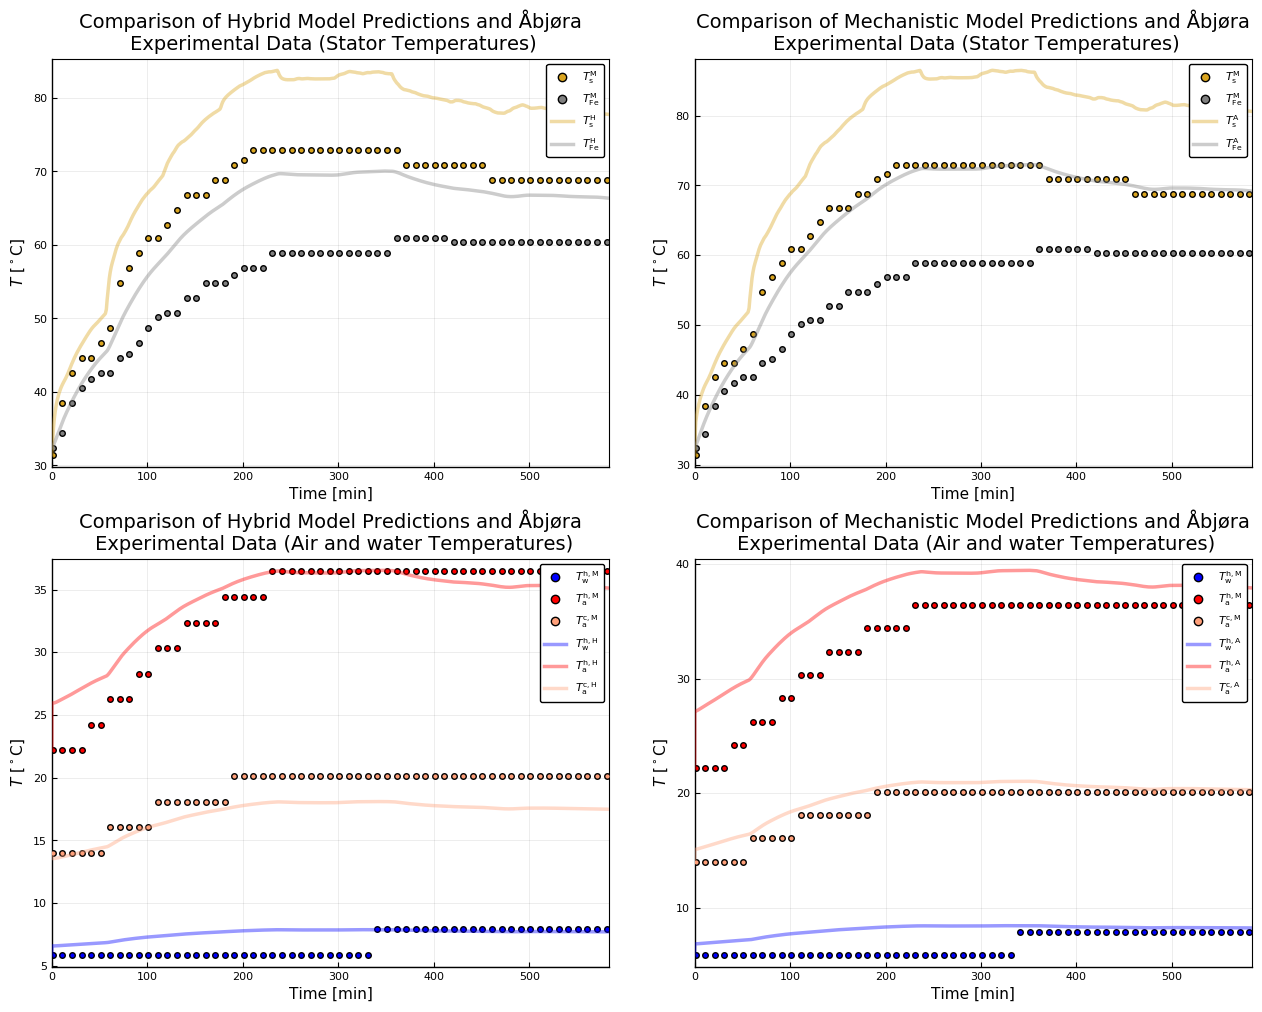

In [17]:
t_s2m(t,u) = (t/60,u) 
scatter(1:10:584,Data[1:10:584,4],label=L"$T_\mathrm{s}^\mathrm{M}$",color ="Goldenrod")
scatter!(1:10:584,Data[1:10:584,5],label=L"$T_\mathrm{Fe}^\mathrm{M}$",color ="gray")
plot!(sol_Hybrid_LR_2,vars=(t_s2m,0,31),label=L"$T_\mathrm{s}^\mathrm{H}$",color ="Goldenrod",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Hybrid_LR_2,vars=(t_s2m,0,32),label=L"$T_\mathrm{Fe}^\mathrm{H}$",color ="gray",lw=LW1,ls=LS1,la=LA3)
fg1=plot!(title="Comparison of Hybrid Model Predictions and Åbjøra\n Experimental Data (Stator Temperatures)")

scatter(1:10:584,Data[1:10:584,6],label=L"$T_\mathrm{w}^\mathrm{h, M}$",color="blue")
scatter!(1:10:584,Data[1:10:584,7],label=L"$T_\mathrm{a}^\mathrm{h, M}$",color="red")
scatter!(1:10:584,Data[1:10:584,8],label=L"$T_\mathrm{a}^\mathrm{c, M}$",color="LightSalmon")
plot!(sol_Hybrid_LR_2,vars=(t_s2m,0,26),label=L"$T_\mathrm{w}^\mathrm{h, H}$",color="blue",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Hybrid_LR_2,vars=(t_s2m,0,29),label=L"$T_\mathrm{a}^\mathrm{h, H}$",color="red",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Hybrid_LR_2,vars=(t_s2m,0,27),label=L"$T_\mathrm{a}^\mathrm{c, H}$",color="LightSalmon",lw=LW1,ls=LS1,la=LA3)
fg2=plot!(title="Comparison of Hybrid Model Predictions and Åbjøra\n Experimental Data (Air and water Temperatures)")


scatter(1:10:584,Data[1:10:584,4],label=L"$T_\mathrm{s}^\mathrm{M}$",color ="Goldenrod")
scatter!(1:10:584,Data[1:10:584,5],label=L"$T_\mathrm{Fe}^\mathrm{M}$",color ="gray")
plot!(sol_Analytic,vars=(t_s2m,0,31),label=L"$T_\mathrm{s}^\mathrm{A}$",color ="Goldenrod",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Analytic,vars=(t_s2m,0,32),label=L"$T_\mathrm{Fe}^\mathrm{A}$",color ="gray",lw=LW1,ls=LS1,la=LA3)
fg3=plot!(title="Comparison of Mechanistic Model Predictions and Åbjøra\n Experimental Data (Stator Temperatures)",left_margin=10mm)

scatter(1:10:584,Data[1:10:584,6],label=L"$T_\mathrm{w}^\mathrm{h, M}$",color="blue")
scatter!(1:10:584,Data[1:10:584,7],label=L"$T_\mathrm{a}^\mathrm{h, M}$",color="red")
scatter!(1:10:584,Data[1:10:584,8],label=L"$T_\mathrm{a}^\mathrm{c, M}$",color="LightSalmon")
plot!(sol_Analytic,vars=(t_s2m,0,26),label=L"$T_\mathrm{w}^\mathrm{h, A}$",color="blue",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Analytic,vars=(t_s2m,0,29),label=L"$T_\mathrm{a}^\mathrm{h, A}$",color="red",lw=LW1,ls=LS1,la=LA3)
plot!(sol_Analytic,vars=(t_s2m,0,27),label=L"$T_\mathrm{a}^\mathrm{c, A}$",color="LightSalmon",lw=LW1,ls=LS1,la=LA3)
fg4=plot!(title="Comparison of Mechanistic Model Predictions and Åbjøra\n Experimental Data (Air and water Temperatures)",left_margin=10mm)


plot(fg1,fg3,fg2,fg4,layout=grid(2,2),size = (1250, 1000),framestyle = :box,legend=:topright,xlabel="Time [min]",
    ylabel=L"$T$ [${}^\circ$C]",xlim = (sol_Hybrid_LR_2.t[1]/60, sol_Hybrid_LR_2.t[end]/60))
figname = "Comparison_of_Mechanistic_Model_Predictions_and_Åbjøra.svg"
savefig(Figpath*figname)